In [1]:
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from preprocess import get_audio_metadata
os.environ["PYTHONPATH"]="./src"

2024-04-06 16:40:24.903295: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 16:40:26.031413: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
location = "./SpeakNow_test_data.csv"
speaknow = pd.read_csv(location)

metadata = get_audio_metadata(location)

Whisper is able to transcribe our audio data to better textual responses.

In [ ]:
whisper = pipeline(
    'automatic-speech-recognition',
    model='openai/whisper-medium',
    chunk_length_s=30,
    device=1,
    generate_kwargs={
        "language": "english",
        "task": "transcribe"
    }
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
transcriptions = whisper(metadata.file_name.values.tolist(), batch_size=8)

In [22]:
transcriptions_only = []
for n, text in enumerate(transcriptions):
    transcriptions_only.append(text['text'])

transcriptions_df = pd.DataFrame({
    'path': metadata.file_name.values.tolist(),
    'transcription': transcriptions_only
})
transcriptions_df.to_csv('./data/transciptions.csv', index=False)

In [3]:
transcriptions_df = pd.read_csv('./data/transciptions.csv')

Here we employ a technique to formulate a cohesion score.

We use a model that uses the RoBERTa transformer and is fine-tuned on queries labeled with completeness scores.

While the fine-tuning isn't directly on cohesion, the scores are related.

The general idea behind this score is:
* assume that a reader has a certain attention bandwidth around a particular focus word.
* the reader will comprehend the section of text according the most complete set of neighboring words.
* so we run permutations of all text subsegments around each word - up to the maximum attention span - through the completeness scoring model.
* then we take the maximum score for all subsegments containing the word.

We note here that for actual written responses, we would segment the responses into sentences. However, spoken transcriptions rarely obey strict grammatical rules, unless they were written and prepared ahead of time.

In this section we construct the text subsegments, keeping track to which audio response each belongs, and where the subsegment is located in the transcription.

In [23]:
maximum_word_attention = 20
text_segments = dict()
word_counts = dict()
for idx, row in transcriptions_df.iterrows():
    text = row.transcription.strip()
    words = text.split(' ')
    word_counts[idx] = len(words)
    for i in range(len(words)):
        for j in range(i+1, min(word_counts[idx], i+maximum_word_attention)+1):
            text_segments[(idx, i, j)] = ' '.join(words[i:j])

Now we batch process it through the Classifier

In [24]:
cohesion = pipeline(
    'text-classification',
    model='Ashishkr/query_wellformedness_score',
    device=1
)

sentences = list(text_segments.values())
scores = cohesion(sentences, batch_size=32)

Some weights of the model checkpoint at Ashishkr/query_wellformedness_score were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Now we map the scores back to their transcriptions and location.

In [25]:
coherences = dict()
for n, ((idx, i, j), _) in enumerate(text_segments.items()):
    coherences.setdefault(idx, np.zeros([word_counts[idx]]))
    coherences[idx][i:j] = np.maximum(scores[n]['score'], coherences[idx][i:j])

And here we see an example of how this method scores a transcription.

The example transcription is:

"So my favorite TV show would be the Firefly. It's an old sci-fi series about a group of interesting and different characters coming together on a journey first place. I really like it mainly because it's a sci-fi series which I genuinely enjoy and because of the cast of the aforementioned characters, the show is not really popular in my country because I don't think it has ever been translated to Russian, so I have only seen it in English and yeah, that's about it."

We see that the cohesion score dips around the subsection: "...coming together on a journey first place. I really like..."

But the rest of the text is generally coherent.

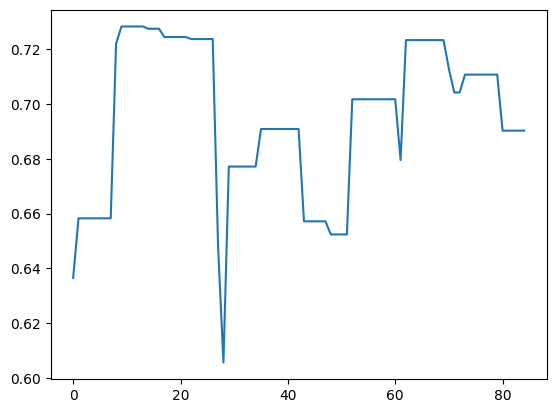

In [41]:
_ = plt.plot(coherences[0])

Here we average the scores along each transcription.

In [55]:
coherence_scores = dict(map(lambda x: (x[0], np.mean(x[1])), coherences.items()))
speakers = list(map(lambda x: int(x[-22:-6]), transcriptions_df.path.values))

And each candidate gets the average score for all their transcriptions.
We see that there is some distribution that we can normalize a bit.

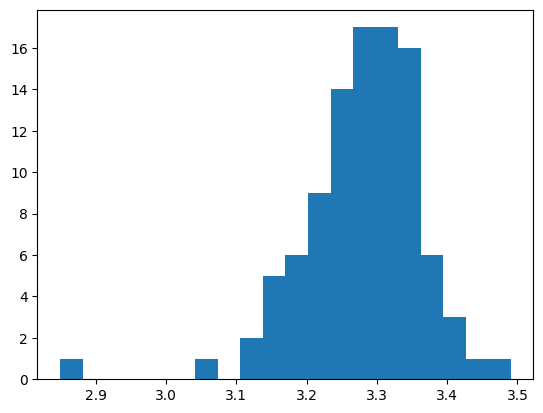

In [58]:
final_coherence_score = dict()
for n, score in coherence_scores.items():
    final_coherence_score.setdefault(speakers[n], 0)
    final_coherence_score[speakers[n]] += score
_ = plt.hist(final_coherence_score.values(), bins=20)

We normalize the scores and see that there is some correlation with the cohesion score given in the SpeakNow dataset

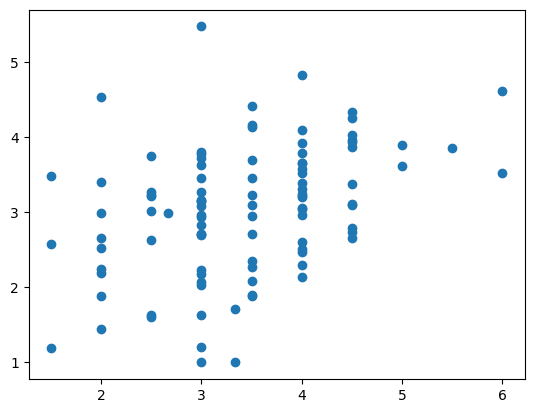

In [77]:
cohesion_df = pd.DataFrame({
    'model_cohesion': list(final_coherence_score.values())
}, index=list(final_coherence_score.keys()))
cohesion_df.loc[:,'speaknow_cohesion'] = 0.
for id, score in final_coherence_score.items():
    cohesion_df.loc[cohesion_df.index == id,'speaknow_cohesion'] = speaknow[speaknow.assessment_id == id].cohesion_avg.values[0]
cohesion_df.loc[:,'model_cohesion'] = np.maximum(1, np.minimum(6,
    (cohesion_df.model_cohesion - cohesion_df.model_cohesion.mean()) / cohesion_df.model_cohesion.std() + 3
))
_ = plt.scatter(cohesion_df.speaknow_cohesion, cohesion_df.model_cohesion)

In [78]:
cohesion_df[cohesion_df.speaknow_cohesion == 3].sort_values('model_cohesion')

,model_cohesion,speaknow_cohesion
1692751298358267,1.000000,3.0
1662420268098487,1.211192,3.0
1691402791754343,1.634704,3.0
1693180250539702,2.035666,3.0
1692747862784476,2.066522,3.0
1691402791754724,2.178756,3.0
1692746758560491,2.234200,3.0
1692747862784414,2.692488,3.0
1691402791754497,2.708645,3.0
1685651809260305,2.711103,3.0


Inspecting a few extremes of the model/speaknow scores, it is hard to say if all these ratings are deserved.

Indeed, the one with 5.5 model rating is shorter and so that is why it is probably clearer.

We can take a few steps to improve the rating:
* Give a higher rating to texts that maintain a high coherence for longer.
* Accept that short responses, if coherent, are better than longer resonses that could have some incoherent text subsegments sprinkled throughout.
* Use a better finetuned model/dataset

In [3]:
from IPython.display import Audio

# Model Score | SpeakNow Score

# Cohesion
# Audio('./data/1692751298358267-1.mp3')  # 1.0 | 3.0
# "I used to live in Durga pur, but now that I am in college, I live in Kolkata near Deshupriya Park. I can't say I hate the place where I live, but I don't like it either. It is Kolkata as you know is filled with concrete and not and there are not many trees there. So it's nice but"
# Audio('./data/1691402791754118-1.mp3')  # 5.5 | 3.0
# "My favorite social media platform is the Instagram application. I'm using it to follow people that are interesting to me. I like it because it's fun and a lot of time I see things that I didn't know that exist."
# Audio('./data/1692687270469550-1.mp3')  # 3.8 | 3.0
# "Staying in a high altitude region where the weather is generally colder. We buy mostly woolen clothes to protect us from the colder weather and prevent cold related diseases like hypothermia. We buy such clothes mostly from the local market and it's not necessarily important to follow fashion because you don't generally have to hop on the trend. It depends mostly on the person's subject to conditions, how he's feeling at that moment and how he feels. This is comfort level."